In [85]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import math
import re

In [86]:
# Determine the absolute path to the src directory (one level up from notebooks)
module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)
import plotting
import utils

In [87]:
ROOT_FOLDER = os.path.dirname(os.getcwd())
RUNS_FOLDER = os.path.join(ROOT_FOLDER, "runs")
SINGLE_RUNS_FOLDER = os.path.join(RUNS_FOLDER, "single_runs")
BATCH_RUNS_FOLDER = os.path.join(RUNS_FOLDER, "batch_runs")
TEST_BATCH_RUNS_FOLDER = os.path.join(BATCH_RUNS_FOLDER, "test")

In [88]:
test_folders = [os.path.join(TEST_BATCH_RUNS_FOLDER, f) for f in os.listdir(TEST_BATCH_RUNS_FOLDER)]
test_display_names = ["v0", "v1", "v2"]

In [89]:
# Setup the folders to explore and their display name
folder1 = os.path.join(BATCH_RUNS_FOLDER, "1_GTSEP_v0-No name-Feb18_Tue_h08")
folder2 = os.path.join(BATCH_RUNS_FOLDER, "2_GTSEP_v1-No name-Feb18_Tue_h08")
folder3 = os.path.join(SINGLE_RUNS_FOLDER, "GTSEP_v2-No name-Feb19_Wed_h09")
results_folders_to_explore = [folder1, folder2,folder3]
display_names = ["128 Model v0", "128 Model v1", "128 Model v2"]
results_folders_to_explore = test_folders
display_names = test_display_names
MAX_COLUMNS = 2

# Alternatively explore all folders in a batch directory

## Figures

Showing: Grid-Related Figures


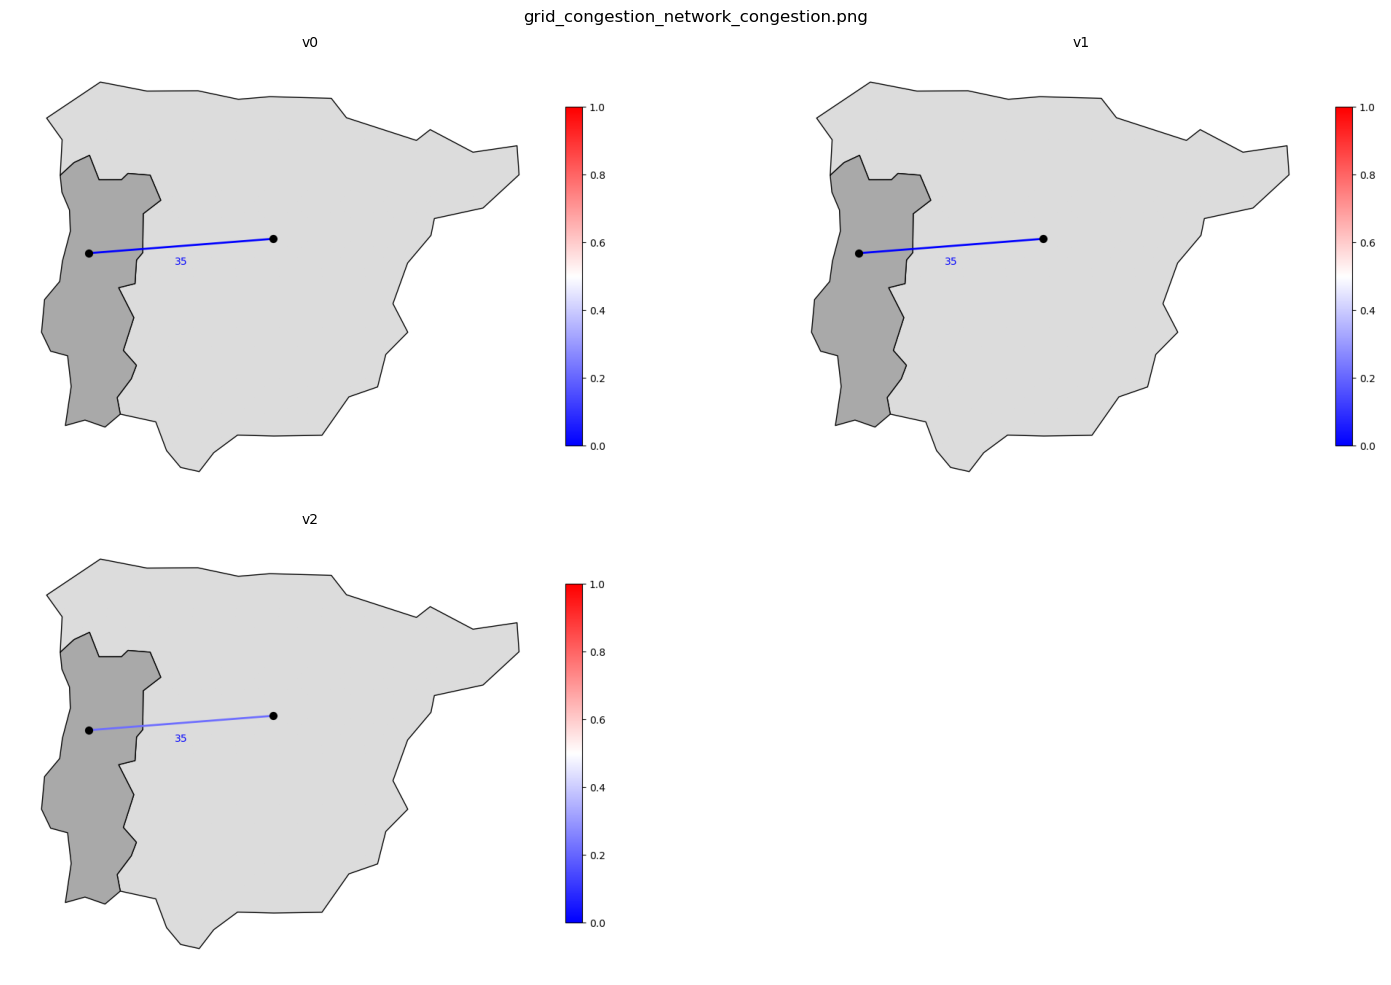

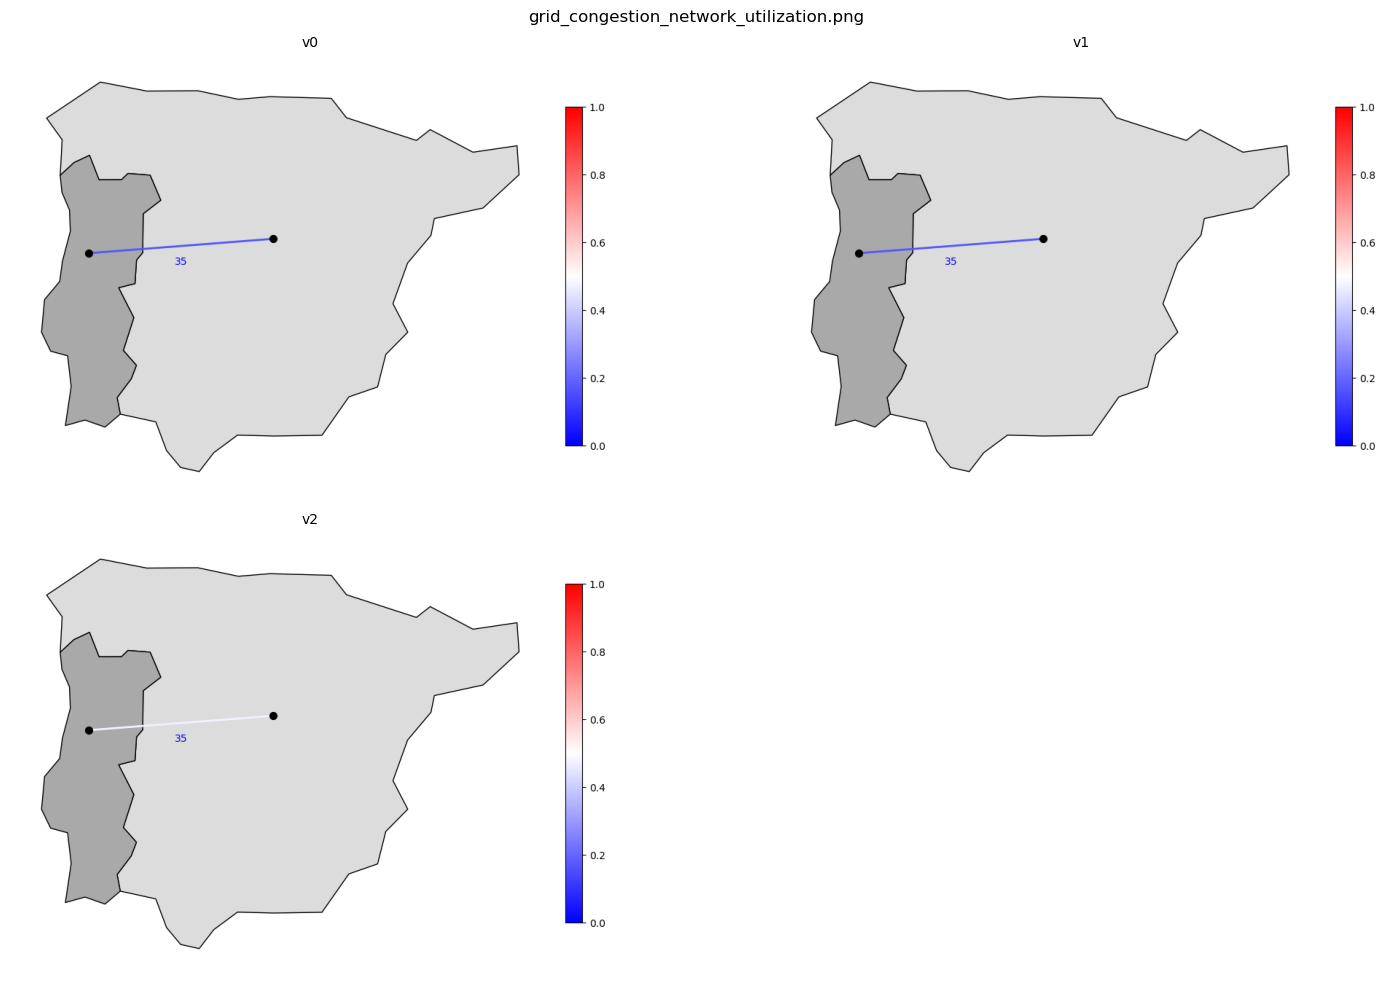

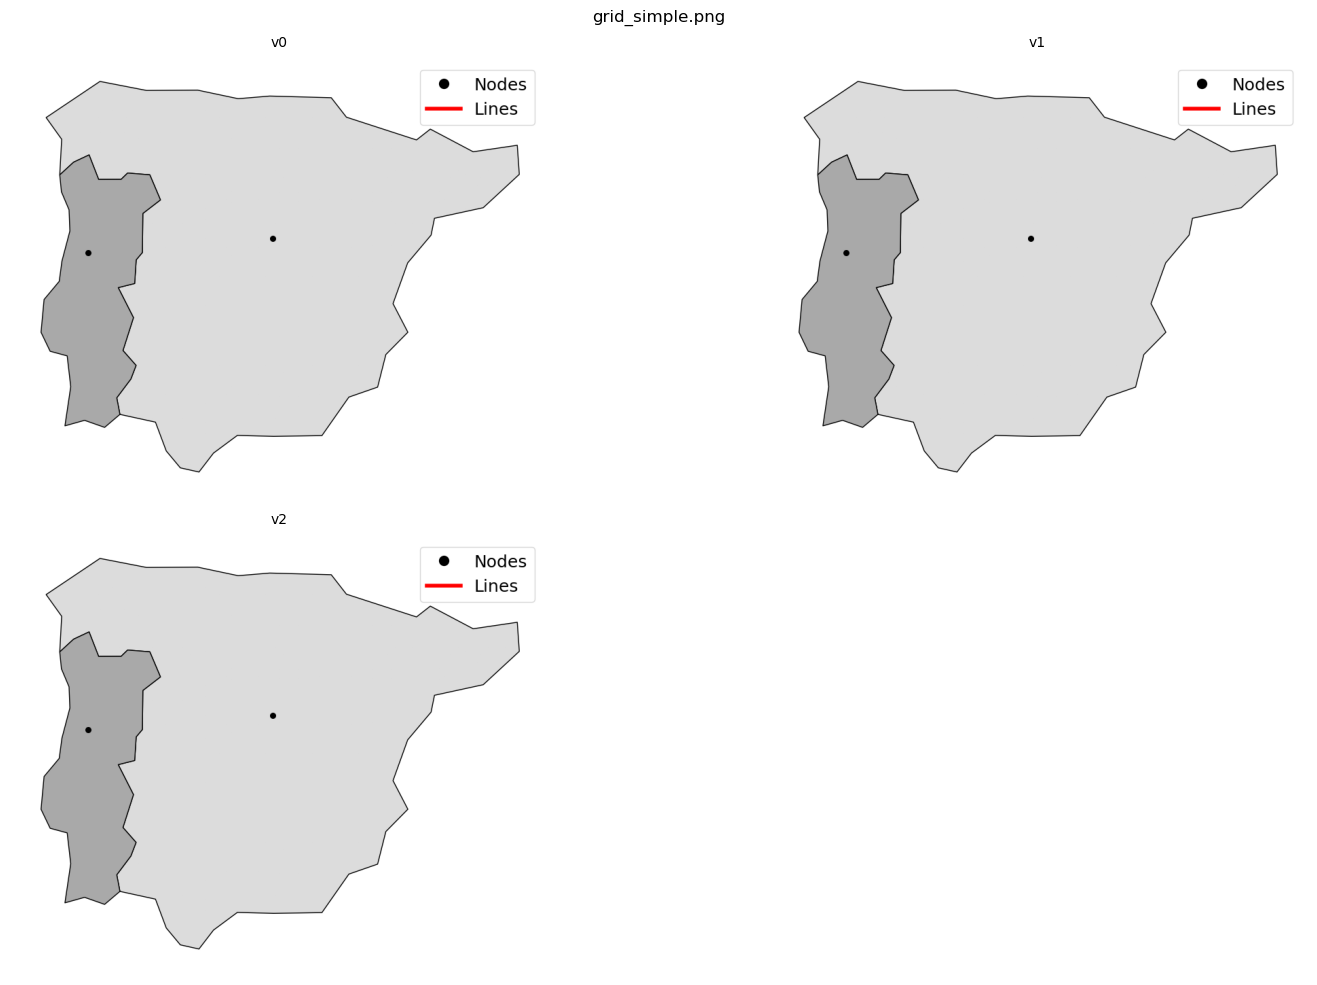

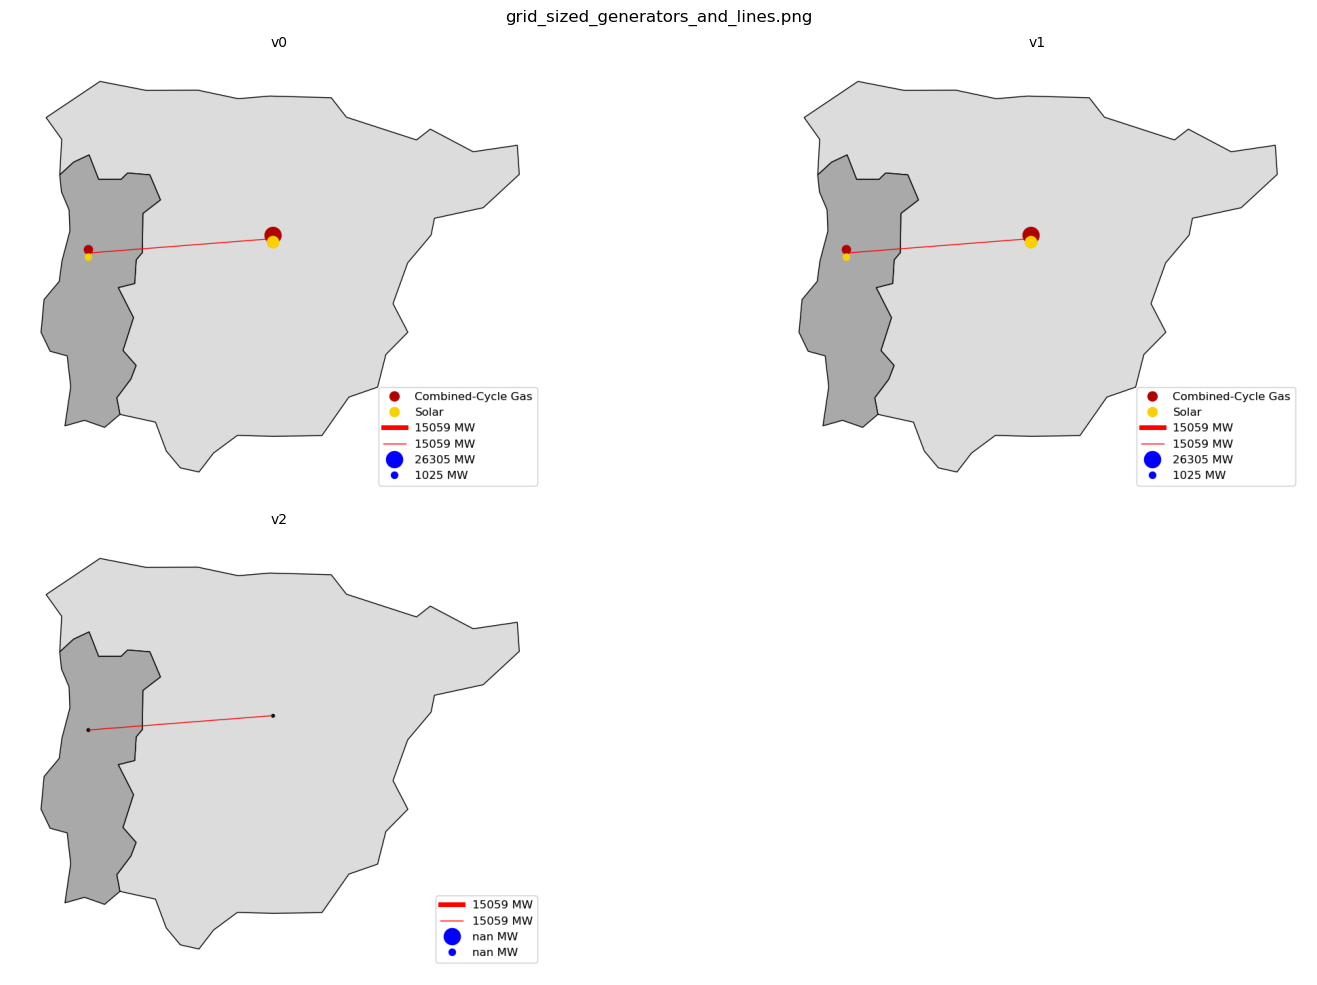

Showing: Bar Figures


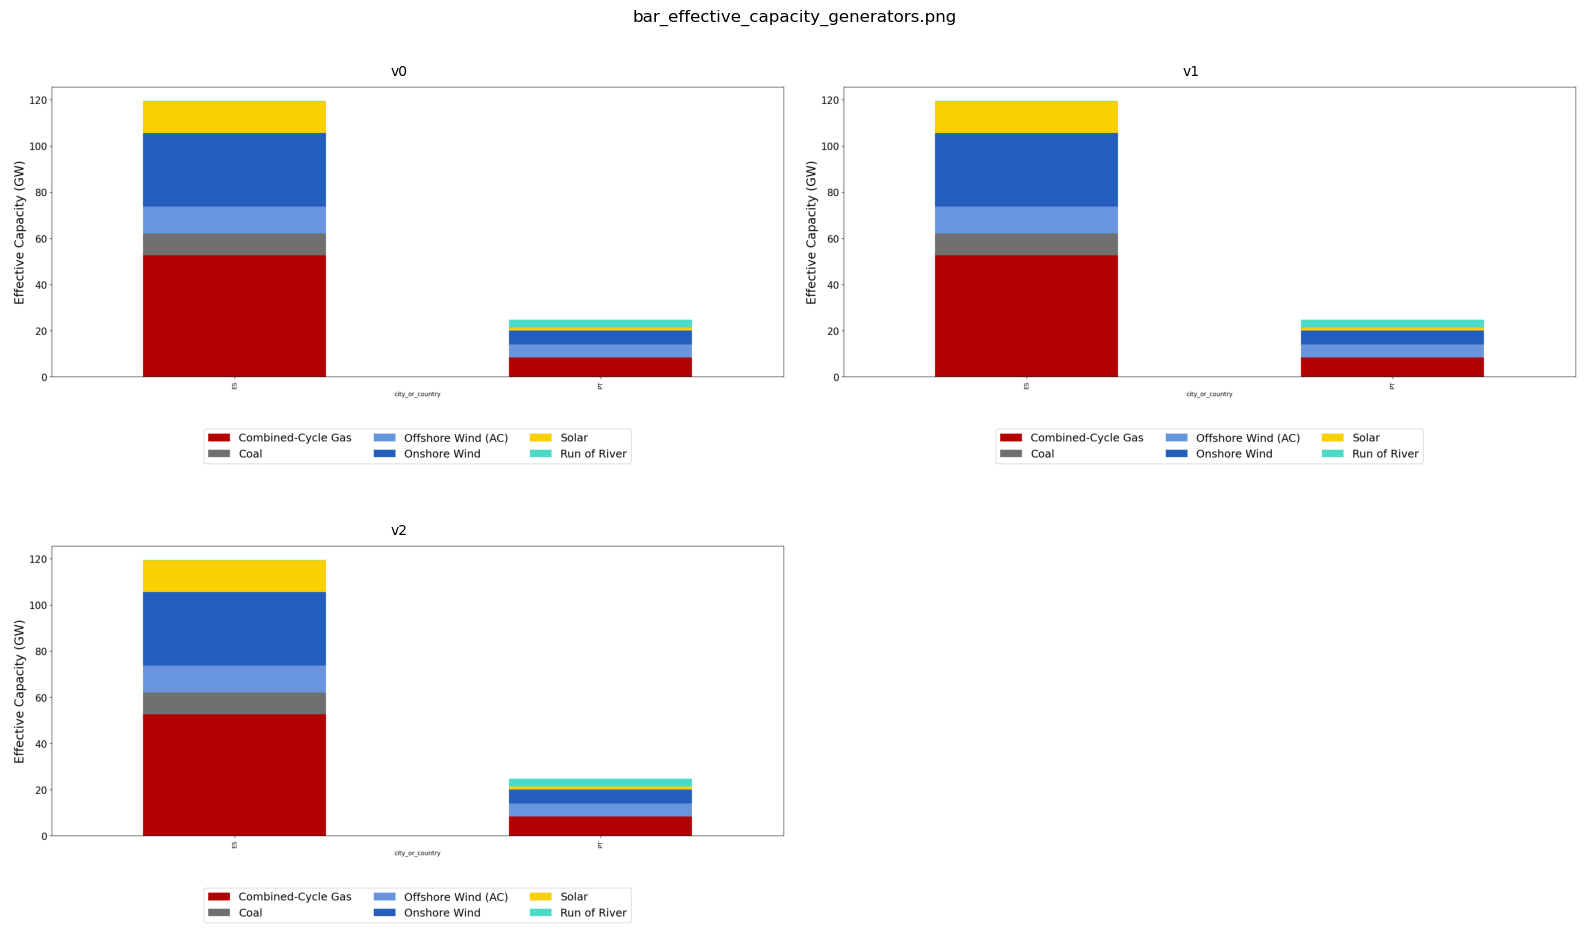

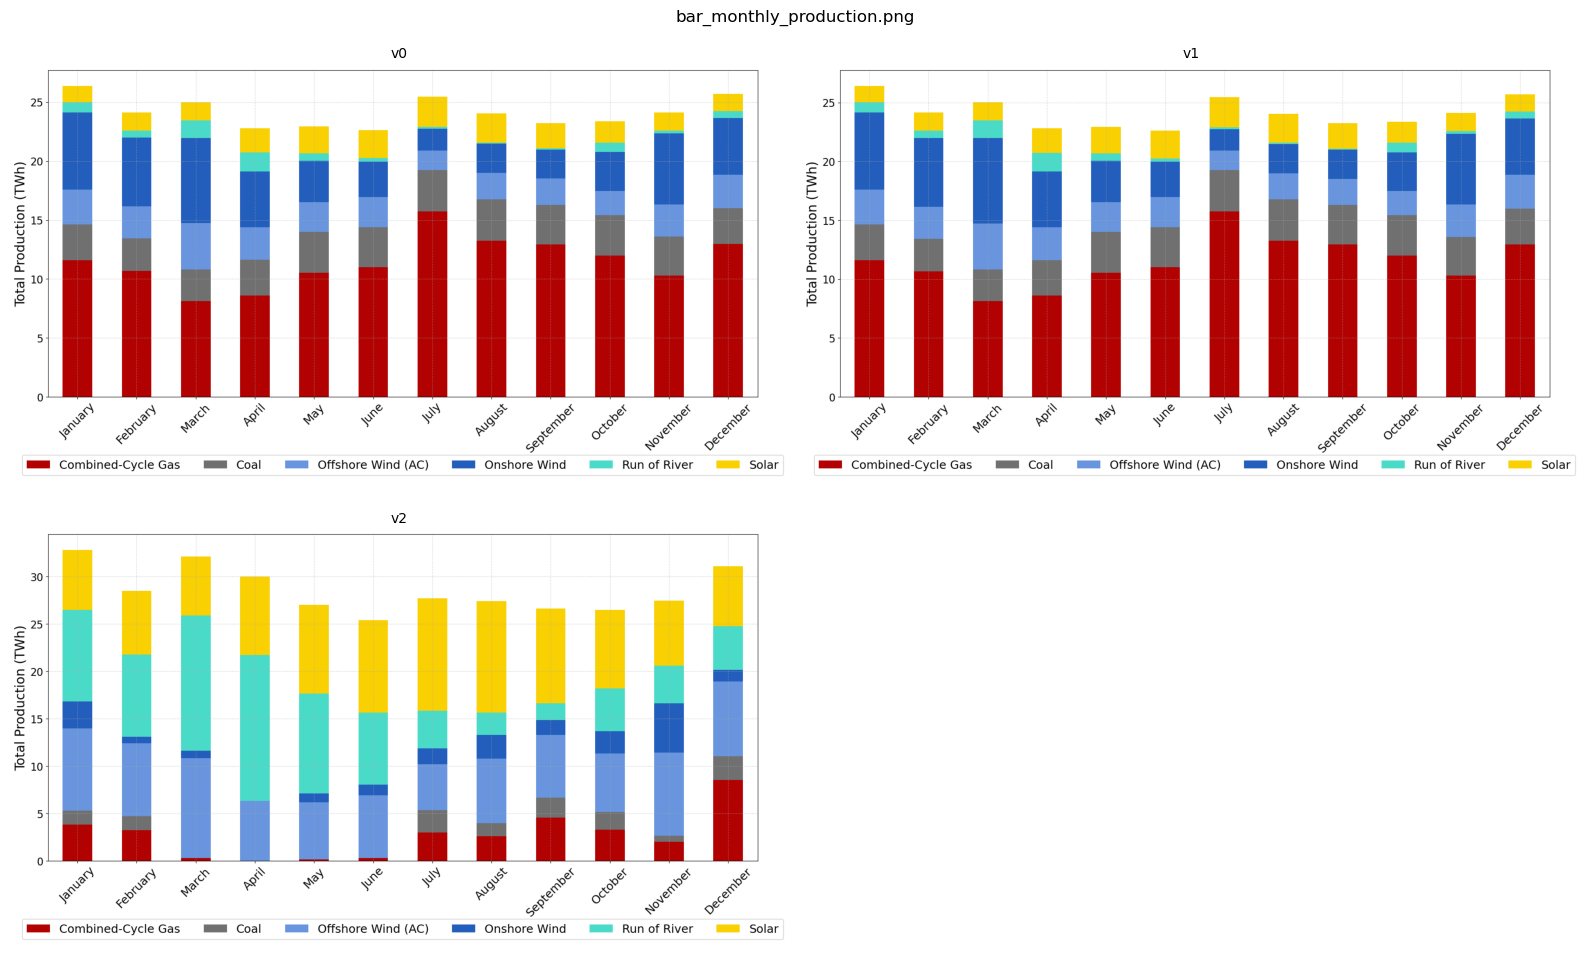

Showing: Battery - General Figures


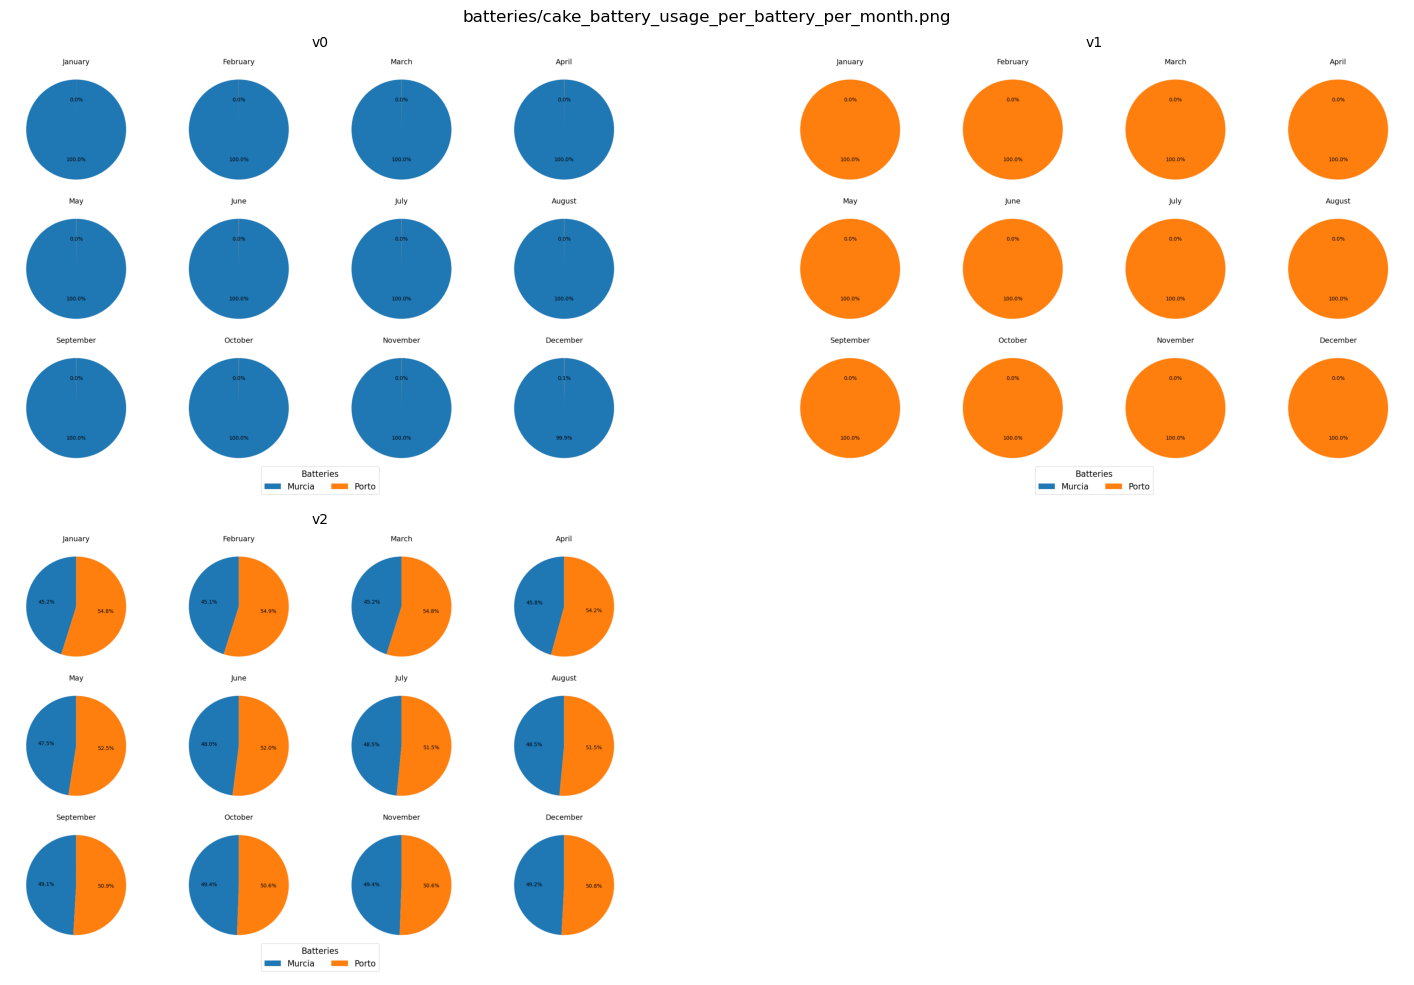

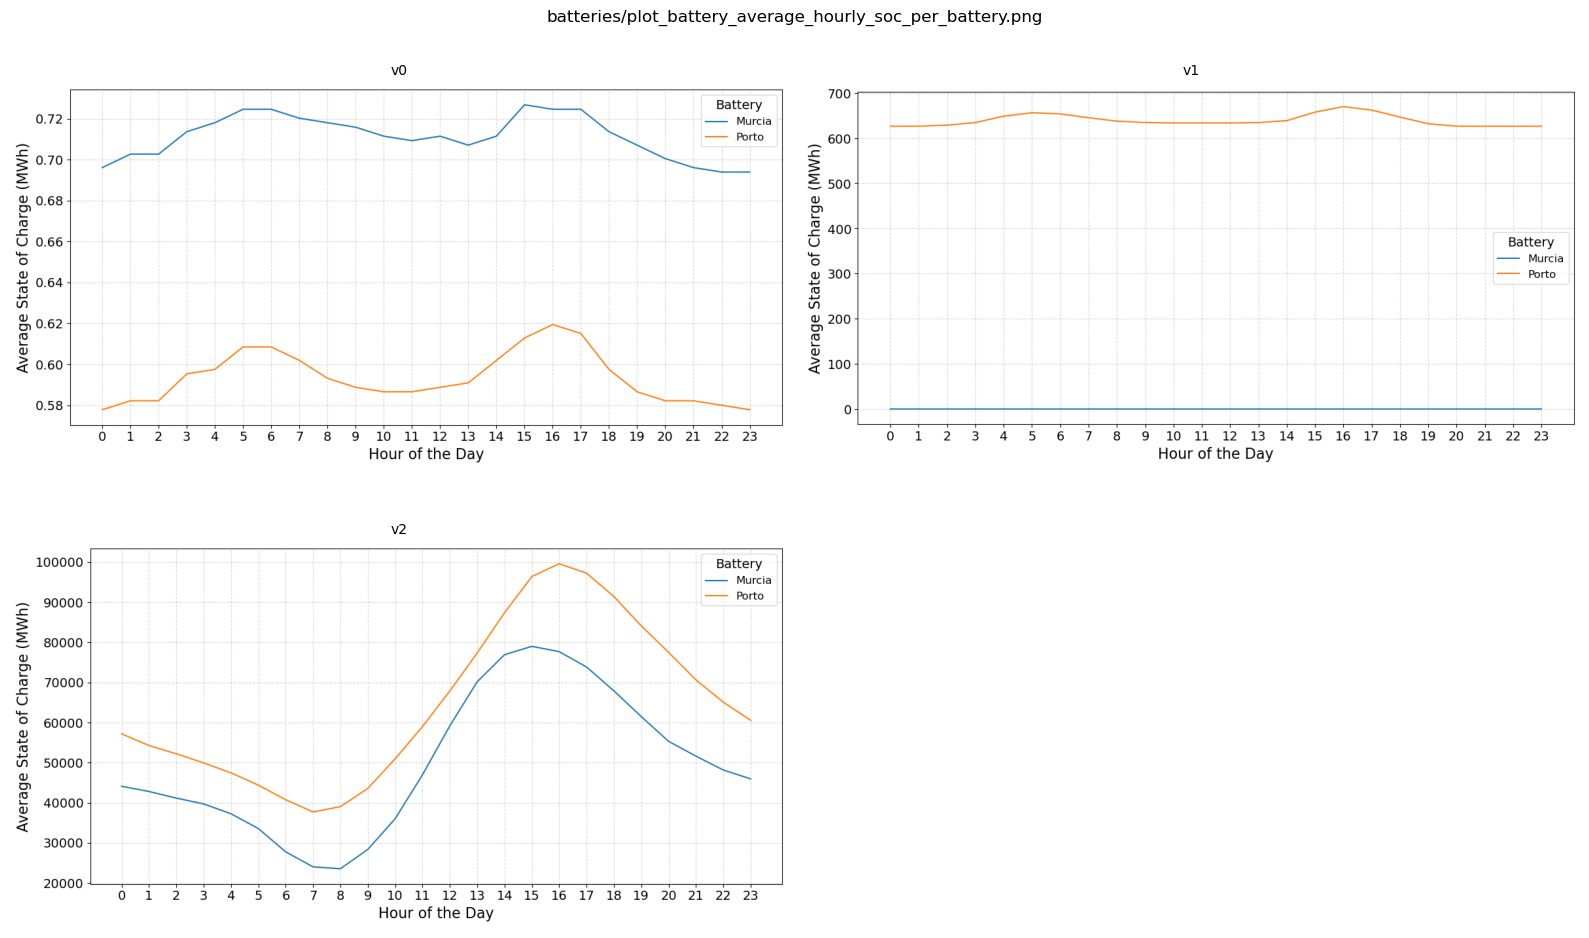

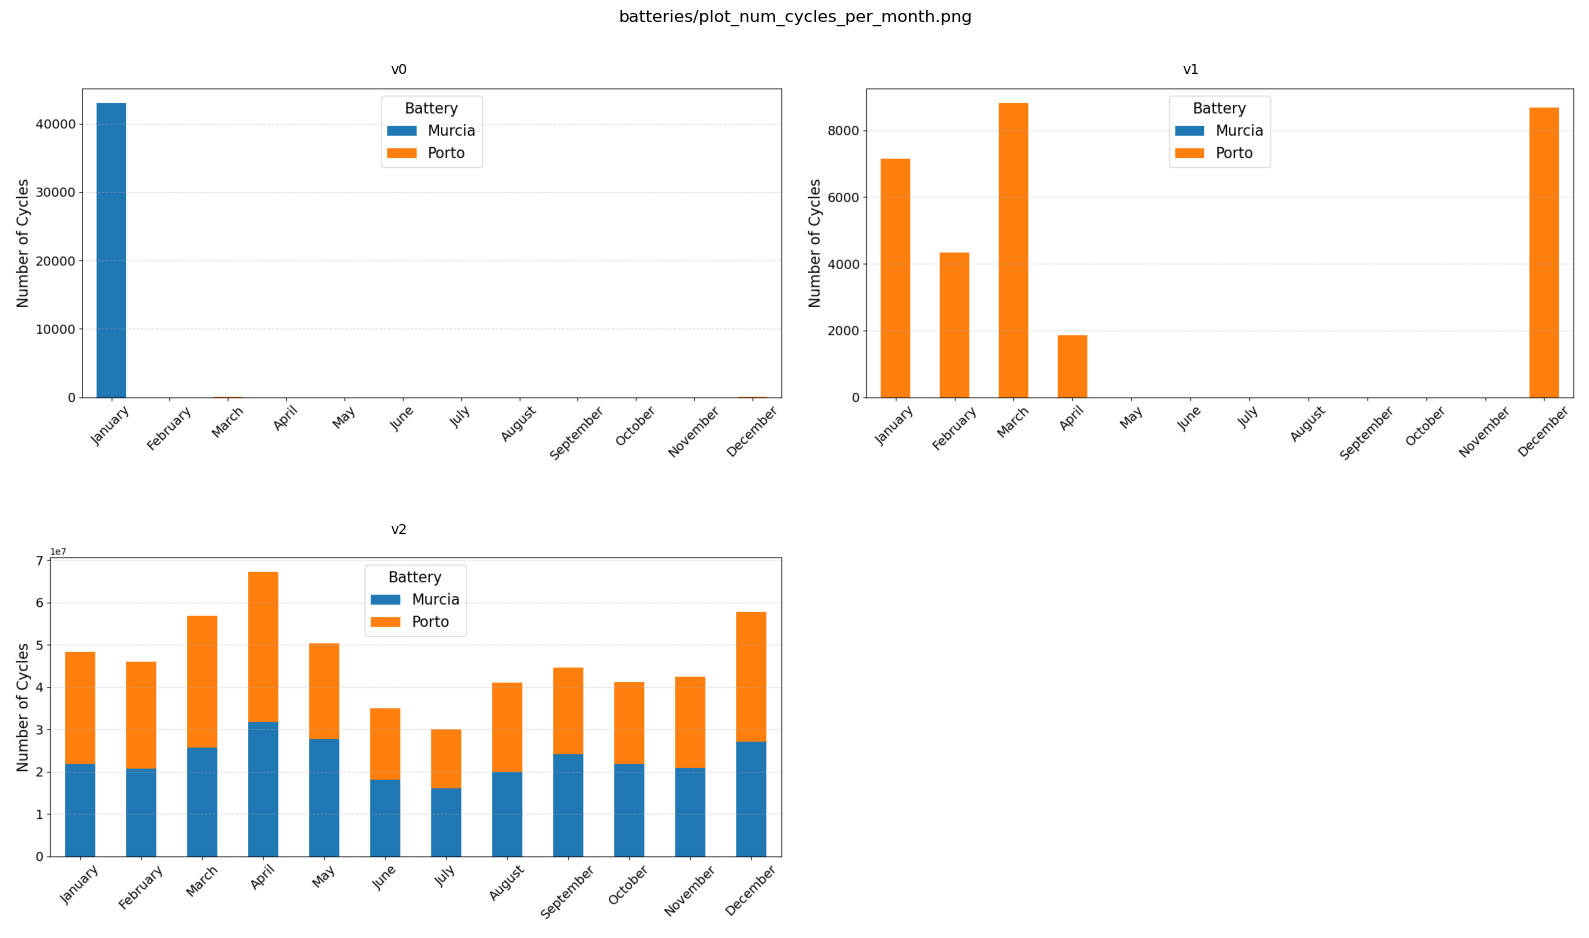

Showing: Remaining Figures
No images found for Remaining Figures.


In [90]:
def categorize_png_files(folder):
    figures_path = os.path.join(folder, "results", "figures")
    categorized_files = {
        "grid": [],
        "bar": [],
        "battery_general": [],
        "battery_hourly_soc": [],
        "battery_city_soc": [],
        "remaining": []
    }

    for root, _, files in os.walk(figures_path):
        for file in files:
            if file.endswith(".png"):
                relative_path = os.path.relpath(os.path.join(root, file), figures_path)
                
                # Normalize to use forward slashes for regex compatibility
                relative_path = relative_path.replace("\\", "/")  

                # Grid figures
                if relative_path.startswith("grid"):
                    categorized_files["grid"].append(relative_path)

                # Bar figures
                elif relative_path.startswith("bar"):
                    categorized_files["bar"].append(relative_path)

                # Battery subfolder
                elif "batteries" in relative_path:
                    if re.match(r"batteries/\d+_plot_battery_average_hourly_soc_month_", relative_path):
                        categorized_files["battery_hourly_soc"].append(relative_path)
                    elif re.match(r"batteries/[A-Za-z]+_plot_battery_average_hourly_soc_by_month_", relative_path):
                        categorized_files["battery_city_soc"].append(relative_path)
                    else:
                        categorized_files["battery_general"].append(relative_path)

                # Remaining figures
                else:
                    categorized_files["remaining"].append(relative_path)
    
    return categorized_files

# Get categorized PNG files from the first folder
reference_folder = results_folders_to_explore[0]
png_categories = categorize_png_files(reference_folder)

# Function to display grouped images
def display_images(image_group, title):
    print("=" * 80)
    print(f"Showing: {title}")
    print("=" * 80)

    if not image_group:
        print(f"No images found for {title}.")
        return

    num_folders = len(results_folders_to_explore)
    num_rows = math.ceil(num_folders / MAX_COLUMNS)  # Dynamically calculate number of rows

    for png_file in image_group:
        fig, axes = plt.subplots(num_rows, MAX_COLUMNS, figsize=(8 * MAX_COLUMNS, 5 * num_rows))

        # Ensure axes is always a 2D list for easy indexing
        if num_rows == 1:
            axes = [axes]  # Convert to list of lists for consistency
        if MAX_COLUMNS == 1:
            axes = [[ax] for ax in axes]  # Ensure row-based structure if only one column
        
        # Flatten for easier iteration
        axes = [ax for row in axes for ax in row]  
        
        for idx, (folder, name) in enumerate(zip(results_folders_to_explore, display_names)):
            img_path = os.path.join(folder, "results", "figures", png_file)
            
            if os.path.exists(img_path):
                img = mpimg.imread(img_path)
                axes[idx].imshow(img)
                axes[idx].axis("off")
                axes[idx].set_title(name, fontsize=10)
            else:
                axes[idx].set_visible(False)

        # Hide unused subplots
        for ax in axes[num_folders:]:  
            ax.set_visible(False)

        plt.suptitle(png_file, fontsize=12)
        plt.tight_layout()
        plt.show()

# Display images in the correct order
display_images(png_categories["grid"], "Grid-Related Figures")
display_images(png_categories["bar"], "Bar Figures")
display_images(png_categories["battery_general"], "Battery - General Figures")
# display_images(png_categories["battery_hourly_soc"], "Battery - Hourly SOC Figures")
# display_images(png_categories["battery_city_soc"], "Battery - City SOC Figures")
display_images(png_categories["remaining"], "Remaining Figures")


## Tables

In [91]:


# Dictionary to store lists of dataframes for each detected table
merged_tables = {}

# Loop over each experiment folder
for folder, name in zip(results_folders_to_explore, display_names):
    tables_path = os.path.join(folder, "results", "tables")

    if os.path.exists(tables_path):
        # Get all CSV filenames in the tables folder
        table_files = [f for f in os.listdir(tables_path) if f.endswith(".csv")]

        for table_file in table_files:
            table_path = os.path.join(tables_path, table_file)
            table_key = table_file.replace(".csv", "")  # key without extension

            # First, read the CSV without specifying an index to count rows
            temp_df = pd.read_csv(table_path)

            if len(temp_df) > 1:
                # For tables with more than one row, we assume the CSV was saved with an index.
                # Read the CSV using the first column as the index.
                df = pd.read_csv(table_path, index_col=0)
                
                # Preserve the existing index name (if it’s None, set a default, e.g. "Category")
                existing_index_name = df.index.name if df.index.name is not None else "Category"
                
                # Create a new MultiIndex combining the experiment name and the existing index.
                new_index = pd.MultiIndex.from_arrays(
                    [[name] * len(df), df.index],
                    names=["Experiment", existing_index_name]
                )
                df.index = new_index

            else:
                # For single-row tables, there is no saved index.
                # Read the CSV normally and insert an "Experiment" column.
                df = temp_df.copy()
                df.insert(0, "Experiment", name)

                # Drop the "Unnamed: 0" column if it exists
                if "Unnamed: 0" in df.columns:
                    df.drop(columns=["Unnamed: 0"], inplace=True)

                # Set 'Experiment' as the index
                df.set_index("Experiment", inplace=True)

            # Save the dataframe in the dictionary under its table key.
            if table_key not in merged_tables:
                merged_tables[table_key] = []
            merged_tables[table_key].append(df)

# Merge dataframes for each table type
final_merged_tables = {table: pd.concat(dfs) for table, dfs in merged_tables.items()}

# Display the merged tables (showing only the first few rows for brevity)
for table_name, df in final_merged_tables.items():
    print(f"\n=== {table_name} ===")
    print(df.head())



=== table_branches_overview ===
            new_branches  new_capacity_mw  util_old_%  util_combined_%  \
Experiment                                                               
v0                     0                0   17.065387        17.065387   
v1                     0                0   17.052514        17.052514   
v2                     0                0   47.312141        47.312141   

            congestion_%  
Experiment                
v0              0.011416  
v1              0.000000  
v2             21.598174  

=== table_cost_breakdown ===
            Building Generators (€)  Building Transmission Lines (€)  \
Experiment                                                             
v0                     5.719480e+08                              0.0   
v1                     5.376758e+08                              0.0   
v2                     0.000000e+00                              0.0   

            Building Batteries (€)  \
Experiment                      

In [92]:
final_merged_tables.keys()

dict_keys(['table_branches_overview', 'table_cost_breakdown', 'table_generators_overview', 'table_generators_production_breakdown', 'table_macro_results'])

In [93]:
table_generators_overview = final_merged_tables["table_generators_overview"]
table_branches_overview = final_merged_tables["table_branches_overview"]
table_cost_breakdown = final_merged_tables["table_cost_breakdown"]
table_generators_production_breakdown = final_merged_tables["table_generators_production_breakdown"]
table_macro_results = final_merged_tables["table_macro_results"]

In [94]:
table_macro_results

,Objective Value (Billion Euro),Generators Built,Potential Generators,Total Generator Capacity (MW),Transmission Lines Expanded,Potential Transmission Lines,Total Transmission Capacity (MW),Batteries Built,Potential Batteries,Total Battery Energy Capacity (MWh),Total Battery Power Capacity (MW),Total Load Shedding (MWh),Total Curtailment (MWh)
Experiment,,,,,,,,,,,,,
v0,10.749164,11.0,11.0,7403.362847,0.0,1.0,0.0,2.0,2,400000.000000,200000.000000,15827.644665,0.000000e+00
v1,10.746011,11.0,11.0,7057.275980,0.0,1.0,0.0,1.0,2,2167.675916,1083.837958,17037.141253,0.000000e+00
v2,8.984524,0.0,11.0,0.000000,0.0,1.0,0.0,2.0,2,486679.084264,243339.542132,0.000000,1.056138e+07


In [95]:
table_cost_breakdown / 1e9

,Building Generators (€),Building Transmission Lines (€),Building Batteries (€),Energy Production Cost (w/o Emissions) (€),CO2 Emissions Cost (€),Production Cost with Emissions (€),Load Shedding Cost (€),Curtailment Cost (€),Total Cost (€)
Experiment,,,,,,,,,
v0,0.571948,0.0,8.783570,6.622480,3.454191,10.076671,0.100506,0.000000,19.532694
v1,0.537676,0.0,0.047600,6.622225,3.454124,10.076349,0.108186,0.000000,10.769811
v2,0.000000,0.0,10.686949,1.646912,0.938000,2.584911,0.000000,1.056138,14.327999


In [96]:
table_generators_production_breakdown / 1e6

Total Production [MW]  New Production [MW]  \
Experiment carrier                                                  
v0         CCGT                   137.704527            16.512192   
           coal                    38.519518             0.000000   
           offwind-ac              31.237465             0.000000   
           onwind                  51.739729             0.000000   
           ror                      7.465797             0.000000   
           solar                   23.145582             3.857597   
           Total                  289.812618            20.369789   
v1         CCGT                   137.696743            16.003833   
           coal                    38.521771             0.000000   
           offwind-ac              31.262387             0.000000   
           onwind                  51.747815             0.000000   
           ror                      7.466083             0.000000   
           solar                   23.145582             3.857597   
           Total                  289.840381            19.861430   
v2         CCGT                    31.737677             0.000000   
           coal                    13.787509             0.000000   
           offwind-ac              87.005160            71.491041   
           onwind                  20.931036             0.000000   
           ror                     87.313124            84.231698   
           solar                  101.817836            91.776880   
           Total                  342.592342           247.499619   

                       Old Production [MW]  Total Production Cost [€]  \
Experiment carrier                                                      
v0         CCGT                 121.192335                5534.870002   
           coal                  38.519518                1086.133674   
           offwind-ac            31.237465                   0.468562   
           onwind                51.739729                   0.776096   
           ror                    7.465797                   0.000000   
           solar                 19.287985                   0.231456   
           Total                269.442829                6622.479790   
v1         CCGT                 121.692910                5534.551580   
           coal                  38.521771                1086.197200   
           offwind-ac            31.262387                   0.468936   
           onwind                51.747815                   0.776217   
           ror                    7.466083                   0.000000   
           solar                 19.287985                   0.231456   
           Total                269.978951                6622.225389   
v2         CCGT                  31.737677                1255.508314   
           coal                  13.787509                 388.765969   
           offwind-ac            15.514119                   1.305077   
           onwind                20.931036                   0.313966   
           ror                    3.081426                   0.000000   
           solar                 10.040956                   1.018178   
           Total                 95.092723                1646.911504   

                       Cost of Buildout [€]  Marginal Cost [€/MWh]  \
Experiment carrier                                                   
v0         CCGT                  481.468759           3.982454e-05   
           coal                    0.000000           2.819697e-05   
           offwind-ac              0.000000           1.500000e-08   
           onwind                  0.000000           1.500000e-08   
           ror                     0.000000           0.000000e+00   
           solar                  90.479241           1.000000e-08   
           Total                 571.948000           6.806151e-05   
v1         CCGT                  447.196562           3.982454e-05   
           coal                    0.000000           2